# Implementations for Sioux Falls Network

These implementations are part of the Bachelor Thesis Computing Traffic Equilibria using Nearest Extreme Point Oracle.
All of the implementations below besides the functions used to import and process the data, have been done by Alexander Fleck, and are to be understood as supporting material for the aforementioned thesis.

# Processing the Data  

First we process the Network, and Store the Data as a pandas Dataframe 

In [1]:
import os
import sys
import numpy as np
import pandas as pd 
import openmatrix as omx
import scipy as scp
import matplotlib.pyplot as plt 

In [2]:
Data=open('SiouxFallsData.txt').readlines()
length=len(Data)
k=0
Datap=[]
Bool=False
for i in Data:
    if i[0]== '~':
        
        Bool=True 
    if Bool==True:
        if k==length-1:
            
            line=i.split('\t')[1:]
        else:
            line=i.split('\t')[1:-1]
        Datap.append(line)
Processed_Network=pd.DataFrame(Datap[1:],columns=Datap[0])

In [3]:
#print(Processed_Network)

In [4]:
#len(Processed_Network)


We also process the optimal Solution to help validate our results 

In [5]:
Optimal=open('Sioux_Optimal.txt').readlines()
Optimal_flow=np.zeros((24,24))
Optimal_cost=np.zeros((24,24))
Pandasframe=[]
for i in Optimal:
    line=i[:-1].split('\t')
    Pandasframe.append(line)
COLUMNS=Pandasframe[0]
Pandasframe=pd.DataFrame(Pandasframe[1:],columns=Pandasframe[0])
    

Now we process the Demands as suggested in the github page, and store in a Matrix $D\in\mathbb{R}^{n\times n}$

In [6]:
def import_matrix(matfile):
    f = open(matfile, 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    matrix = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        orig=int(orig[0])

        d = [eval('{'+a.replace(';',',').replace(' ','') +'}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        matrix[orig] = destinations
    zones = max(matrix.keys())
    mat = np.zeros((zones, zones))
    for i in range(zones):
        for j in range(zones):
            # We map values to a index i-1, as Numpy is base 0
            mat[i, j] = matrix.get(i+1,{}).get(j+1,0)

    index = np.arange(zones) + 1
    return mat



In [7]:
D=import_matrix('Sioux_Demands.txt')
print(D)

[[   0.  100.  100.  500.  200.  300.  500.  800.  500. 1300.  500.  200.
   500.  300.  500.  500.  400.  100.  300.  300.  100.  400.  300.  100.]
 [ 100.    0.  100.  200.  100.  400.  200.  400.  200.  600.  200.  100.
   300.  100.  100.  400.  200.    0.  100.  100.    0.  100.    0.    0.]
 [ 100.  100.    0.  200.  100.  300.  100.  200.  100.  300.  300.  200.
   100.  100.  100.  200.  100.    0.    0.    0.    0.  100.  100.    0.]
 [ 500.  200.  200.    0.  500.  400.  400.  700.  700. 1200. 1400.  600.
   600.  500.  500.  800.  500.  100.  200.  300.  200.  400.  500.  200.]
 [ 200.  100.  100.  500.    0.  200.  200.  500.  800. 1000.  500.  200.
   200.  100.  200.  500.  200.    0.  100.  100.  100.  200.  100.    0.]
 [ 300.  400.  300.  400.  200.    0.  400.  800.  400.  800.  400.  200.
   200.  100.  200.  900.  500.  100.  200.  300.  100.  200.  100.  100.]
 [ 500.  200.  100.  400.  200.  400.    0. 1000.  600. 1900.  500.  700.
   400.  200.  500. 1400. 1000. 

Now we define the Components required to mathematically express the Problem, therefore let for $(i,j)\in  A$ the Set of arcs and flow $x_{ij}$.
\begin{align*}
&l_{ij}\text{ be the length of a in this case equal to the free flow travel time }\\
&C_{ij} \text{ be the so called capacity,}\\
&B:=0.15 \text{ the BPR-Value, }\\
&a_{ij} \text{ be the free flow travel time between Nodes} \\
&P_{ij} \text{ be the Power in this case set as }4\\
&b_{ij}=a_{ij}\cdot\frac{B}{C_{ij}^{P_{ij}}}\\
&f_{ij}(x)=a_{ij}x_{ij}+\frac{b_{ij}}{5}x_{ij}^5, \text{ be the Integral of the Link travel time.}\\
&\frac{\partial f}{\partial x_{ij}^s}(x)=a_{ij}+x_{ij}^{P_{ij}}\cdot b_{ij}=\frac{\partial f_{ij}(x)}{\partial x_{ij}} \text{ , be  the Link travel time}.
\end{align*}
We will assume for now that the cost is only determined by the link travel time.

In [8]:
B=np.zeros((24,24))
free_flow=np.zeros((24,24))
C=np.zeros((24,24))
P=np.zeros((24,24))
b=np.zeros((24,24))
toll=np.zeros((24,24))
length=np.zeros((24,24))
Edges1=[]
Link_travel_Time=np.zeros((24,24))
Optimal_flow=np.zeros((24,24))
Optimal_cost=np.zeros((24,24))
Of1=Pandasframe[COLUMNS[2]]
Oc1=Pandasframe[COLUMNS[3]]
B1=Processed_Network['init_node']
B2=Processed_Network['term_node']
c1=Processed_Network['capacity']
a1=Processed_Network['free_flow_time']
p1=Processed_Network['power']

l=0
j=0
while j< len(B1):
   
    if int(B1[j])-1==l:
        B[int(B1[j])-1][int(B2[j])-1]=0.15
        free_flow[int(B1[j])-1][int(B2[j])-1]=float(a1[j])
        C[int(B1[j])-1][int(B2[j])-1]=float(c1[j])
        P[int(B1[j])-1][int(B2[j])-1]=float(p1[j])
        b[int(B1[j])-1][int(B2[j])-1]=free_flow[int(B1[j])-1][int(B2[j])-1]*0.15/(C[int(B1[j])-1][int(B2[j])-1]**4) 
        Optimal_flow[int(B1[j])-1][int(B2[j])-1]=float(Of1[j])
        Optimal_cost[int(B1[j])-1][int(B2[j])-1]=float(Oc1[j])
        Edges1.append([int(B1[j])-1,int(B2[j])-1])
        j=j+1
    else:
       
        l=l+1    


In [9]:
#print(Optimal_cost)

# Next we will set the mathematical Problem

First the objective function defined for a flow $x:A\to \mathbb{R}$ as 
\begin{align*}
f(x)=\sum_{a\in A} f_{a}( x)=\sum_{(i,j)\in A}a_{ij}x_{ij}+\frac{b_{ij}}{5}x_{ij}^5
\end{align*}
with gradient 
\begin{align*}
\nabla f(x)=\sum_{(i,j)\in A} \frac{\partial f_{ij}(x)}{\partial x_{ij}}=
\begin{bmatrix}a_{11}+x_{11}^{P_{11}}\cdot b_{11}&\dots&a_{1n}+x_{1n}^{P_{1n}}\cdot b_{1n}\\
\vdots&a_{ij}+x_{ij}^{P_{ij}}\cdot b_{ij}&\vdots
\\ 
a_{n1}+x_{n1}^{P_{n1}}\cdot b_{n1}&\dots&a_{nn}+x_{nn}^{P_{nn}}\cdot b_{nn} 
\end{bmatrix}
\end{align*}



Our Goal is to minimize
\begin{align*}
&\min f(x)\\
&s.t: D_{js}+ \sum_{i} x_{ij}^s=\sum_{k} x_{jk}^s \text{ for all }j\\
&x_{ij}^s\geq 0
\end{align*}
using the Frank-Wolfe Method which means we need an efficient way of solving 
\begin{align*}
\min s^\top \nabla f(x)
\end{align*}
with $s\in\tilde{D}$, the Polyhedron given by the constraints from the original problem.


# Solving the call for the Oracle 

Having presented both the formulation of the problem and the algorithm we will first use to solve it, we now get to discuss how to implement the algorithm efficiently. Since the main difficulty for the implementation of the Frank-Wolfe Method in this case, relies on how to solve the call for the oracle we will discuss this first.
As seen in section 1.3 the Frank-Wolfe Algorithm solves in every iteration the subproblem 
\begin{equation}
\begin{aligned}
& \underset{v\in \mathcal{V}}{\text{min}}
& & v^\top\nabla f(x)  
\end{aligned}
\end{equation}
which for our case is given by 
\begin{equation}
\begin{aligned}
& \underset{g(y)=0}{\underset{y\geq 0}{\text{min}}}
& & \sum_{(i,j)\in A}\sum_{s=1}^p c_{ij}y_{ij}^s\geq\sum_{s=1}^p & \underset{g(y)=0}{\underset{y\geq 0}{\text{min}}}
& & \sum_{(i,j)\in A}c_{ij}y_{ij}^s
\end{aligned}
\end{equation}
Where $g$ ensures that the flow circulation constraints are satisfied REFER TO THE CONSTRAINTS.
This allows us to solve the call for the oracle by solving the subproblem one block at a time, which means minimizing the cost of sending $D_{js}$ units of flow for all nodes $j$ to node $s$. This can be done using the Dijkstra algorithm using the costs  $c_{ij}$ as distances between nodes. This strategy does not violate the constraints imposed by $g$ . Finally we only need to sum up the solutions of the individual blocks to obtain the direction we will then minimize along.

In [10]:
def smallest_distance(unvisited_Network):
    '''
    

    Parameters
    ----------
    unvisited_Network : List
        Contains all unvisited Nodes .

    Returns
    -------
    a : Node
        looks among all unvisited Nodes for the one with smallest Distance to the initial .
.

    '''
    a=unvisited_Network[0]
    for i in unvisited_Network:
        if not i.Visited:
            if i.Distance<a.Distance:
                a=i
    return a
def Notallvisited(Network):
    if Network.unvisited_Network!=[]:
        return True 

def Dijkstra(Network,x0):
    #print('Dijkstra')
    Network.unvisited_Network=list(Network.Nodes)
    for i in Network.Nodes:
        if not i==x0:
            i.Distance=np.inf
            i.Predecessor=None
        else:
            i.Distance=0
            i.Predecessor=None 
            
    while Notallvisited(Network):
        #print(len(Network.Nodes))
        
        a=smallest_distance(Network.unvisited_Network)
        Network.unvisited_Network.remove(a)
        #Network.unvisited_Network.remove(a)
        for j in a.Edges:
            #j is an Edge a=(0,1) and has the attribute cost
            #print(j.Tuple[1],'Index')
            #print(len(Network.Nodes))
            if Network.Nodes[j.Tuple[1]].Visited==False:
                if Network.Nodes[j.Tuple[1]].Distance>j.Cost+a.Distance:
                   Network.Nodes[j.Tuple[1]].Distance=j.Cost+a.Distance
                   Network.Nodes[j.Tuple[1]].Predecessor=a

            
        

In [11]:
class Edge:
    def __init__(self,Tuple,Cost ):
        self.Tuple=Tuple
        self.Cost=Cost
    
class Node:
    def __init__(self,Edges,Distance,key):
        self.Edges=Edges
        self.Distance=0
        self.key=key
        self.Predecessor=None
        self.Visited=False
    def print_edges(self):
        print('Edges outgoing from Node ',self.key+1)
        for i in self.Edges:
            print(i.Tuple+np.ones(2))

class Class_Network:
    def __init__(self,Nodes,Edges ):
        self.Nodes=Nodes
        self.unvisited_Network=list(Nodes)
        self.Edges=list(Edges)
#class Residual_Network:
    
        

In [12]:

def Initialize_Network(xk):
    '''
    The Link Travel Time is the Gradient in xk
    Iterate over all of the nodes 
    for node_i:
        set a list of Edges going from (i,other)
        
        
        
    '''
    n=24
    #print('Initialize Network')
    Y=np.zeros((n,n))
    
    Link_travel_Time=free_flow+b*xk**4
    #print(Link_travel_Time)
    Nodes=[ ]
    
   
    for j in range(n):
        Edges=[] 
        
        current=Processed_Network. loc[Processed_Network['init_node'] == str(j+1)]
        
        
        for i in current['term_node']:
                Edges.append(Edge(np.array([j,int(i)-1]),Link_travel_Time[j,int(i)-1]))

        Nodes.append(Node(Edges,0,j))
    
    Network=Class_Network(Nodes,Edges1)
    
    return Network



# Solving the Oracle 

In [13]:
def Fortran_Op(y,Network,Start):
    #print('Fortran')
    #for i in Network.Nodes:
        #print(i.Predecessor)
    
    #print('Start',Start)
    for j in Network.Nodes:
    
        Current_Node=j
        while Current_Node!=Start:
            
            #print
            #print(Current_Node.key)
            #print(Start.key)
            
            y[Current_Node.Predecessor.key][Current_Node.key]+=D[j.key][Start.key]
            #print(D[j.key][Start.key],'D')
            Current_Node=Current_Node.Predecessor
        
        

In [14]:
def Oracle(xk):
    Y=np.zeros((24,24))
    Network=Initialize_Network(xk)
    
    s=0
    Start=Network.Nodes[s]
    while s<len(Network.Nodes):
        
        #print(s,len(Network.Nodes),s<24)
        Start=Network.Nodes[s]
        Dijkstra(Network,Start)
        Fortran_Op(Y,Network,Start)
        s=s+1
        
        
    return Y

    
    
    
    
    
    
    

# Actual Frank-Wolfe Algorithm 

We will now implement a standard Version of the Frank-Wolfe Algorithm 

In [15]:
def Initial():
        '''
        gives us an Initial feasible starting Point, by 
        sending all of the flow between every Od-pair through the 
        cheapest route in terms of free flow travel time 
        '''
        xk=np.zeros((24,24))
        Network=Initialize_Network(xk)

        s=0
        Start=Network.Nodes[s]
        while Start.key<len(Network.Nodes)-1:
            #print(s)
            Dijkstra(Network,Start)
            Fortran_Op(xk,Network,Start)
            s=s+1
            Start=Network.Nodes[s+1]
        return xk


In [16]:
def Objective(x):
    '''
    Objective function
    '''
    Link_cost=free_flow*x+x**5*(b/5)
    Link_cost1=free_flow+b*x**4
    
    return np.sum(Link_cost)/100000


# Stepsizes 

In [17]:

def stepsize1(i)  : 
    '''
    Easy choice of stepsize 
    '''
    return 2/(i+1)
def stepsize2(w,xk):
    i=0
    alpha_i=1/(i+1)
    current=xk
    while Objective(current+alpha_i*(w-current))<Objective(current):
        i+=1
        print(i)
        alpha_i=1/(i+1)
        current=current+alpha_i*(w-current)
    return alpha_i    
def line_search(x,v):
    '''
    computes a stepsize using a line search with an error of 1/200 
    '''
    value_small=Objective(x)
    stepsize_final=1/2
    direction=1
    for i in range(2,200):      
        if value_small>Objective(x+(stepsize_final+direction*1/i)*(v-x)):
        
            #if the value decreases when going to the right 
            value_small=Objective(x+(stepsize_final+direction*1/i)*(v-x))
            stepsize_final+=direction*1/i
        else:
            direction=-direction
            #if the value does not decrease when going to the right, go left 
            value_small=Objective(x+(stepsize_final+direction*1/i)*(v-x))
            stepsize_final+=direction*1/i
    return stepsize_final
        

def stepsize_NEP(Stepi,current,new):
    
    '''
    Stepsize proposed in NEP Algorithm 1
    '''
    if Objective(current)>Objective(new):
        return Stepi
    else: 
        return 0
    

In [18]:

def Frank_Wolfe(xk,T):
    '''
    Standard Frank Wolfe Algorithm, to switch between stepsizes recall the different stepsize functions 
    '''
    i=0
    A=np.zeros(T)
    while i<T:
        
        
        w=Oracle(xk)
        #alpha_i=stepsize1(i)
        alpha_i=line_search(xk,w)
        
        A[i]=Objective(xk)
        print(A[i])
        xk=xk+alpha_i*(w-xk)
        
        i=i+1
        
    return xk,A

# We now Test the Algorithm 

In [19]:
x0=Initial()
#x0=np.zeros((24,24))
T=20
Network=Initialize_Network(x0)
Result=Frank_Wolfe(x0,T)
w=Oracle(x0)


153.87145218267509
60.45188837073294
52.83358938161854
50.881545210747085
47.87801768698962
46.88694760668836
45.47724002572441
44.89279414404043
44.39504568929955
44.04666030435909
43.67030905919762
43.48609405204043
43.366177836273934
43.26417215386176
43.182305480216534
43.09192263471628
43.01969748855659
42.98159832277208
42.91744089533088
42.88360235763913


Text(0.5, 1.0, 'Standard Frank-Wolfe')

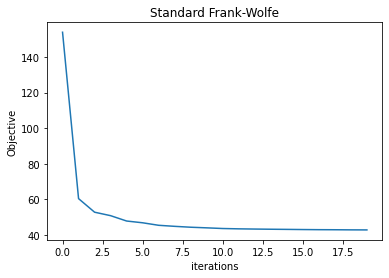

In [20]:
plt.plot(np.arange(T),Result[1])
plt.ylabel('Objective')
plt.xlabel('iterations')
plt.title('Standard Frank-Wolfe')

# Validation via optimal results presented in Github

Value of the starting point $x_0$

In [21]:
print(Objective(x0))

153.87145218267509


Value of the computed iterate $x_{20}$

In [22]:
print(Objective(Result[0]))

42.82306390319573


Value of the Optimal flow found in Git evaluated with the Objective function used 

In [23]:
print(Objective(Optimal_flow))

42.3133528710744


Value of the Optimal flow found in Git 

In [24]:
 print(42.31335287107440)

42.3133528710744


So far the results appear to  be correct.

# Frank wolfe with Nearest Extreme Point Oracle 

Let $\lambda>0$ be a parameter to be tuned. We first consider the following rewriting of the oracle 
\begin{align*}
     &\min_{v \in \mathcal{V}} v^\top\nabla f(x)+\lambda||v-x||^2\\
     &=\min_{v\in\mathcal{V}}\left|\left| v-\left(x -\frac{1}{2\lambda}\nabla f(x)\right)\right|\right|^2\\
     &=\min_{v\in\mathcal{V}}\left|\left| v-\left(x -\frac{1}{2\lambda}\nabla f(x)\right)\right|\right|^2\\
\end{align*}
Next by setting $y:=\left(x -\frac{1}{2\lambda}\nabla f(x)\right)$, then for $c\in \mathbb{R}^n$ with $c\geq 0$
\begin{align*}
    &\min_{v\in\mathcal{V}}||v-y||^2\\
    &=\min_{v\in\mathcal{V}}(v-y)^\top(v-y)\\
    &=\min_{v\in\mathcal{V}}v^\top v-2v^\top y +y^\top y\\
    &=\min_{v\in\mathcal{V}}v^\top v-2v^\top y \\
    &=\min_{v\in\mathcal{V}}v^\top 1\cdot 10^p-2v^\top y \\
    &=\min_{v\in\mathcal{V}}v^\top (1\cdot 10^p-2y)\\
\end{align*}
Now if we are able to set $p\in \mathbb{N}$, such that $ 10^p\geq 2\left(x_{ij}-\frac{1}{2\lambda}c_{ij}(x)\right)$ for all $(i,j)\in A$, then we can solve the call for the Oracle with the same Method we used for the standard Frank-Wolfe Oracle.
One Remaining aspect is how to choose $\lambda$, so far it is clear we need to choose a $\lambda$ small enough not to set too much weight on the Penalty given by $\lambda||v-x||^2$ but not so small that the penalty becomes trivial. The solution to this Problem is found on Algorithm 1 from NEP. 
In every Iteration of the Oracle we choose 
$\lambda:=  \frac{\beta\mu_t}{2}$ where $(\mu_t)_{t\in \mathbb{N}}$ is a sequence of predetermined stepsizes, and $\beta$ remains to be estimated. 

We now set $p=6$ as a first estimate, since 

In [25]:
np.sum(D)

360600.0

And thus we obtain

In [26]:

#    print(np.linalg.norm(b**2*i**8)**2/np.linalg.norm(i**2))
p=6
M=np.ones((24,24))*10**p
#beta=np.linalg.norm(b**2*M**8)**2/np.linalg.norm(M**2)
beta=np.linalg.norm(b*4*M**(3))**2
print(beta)

953394976.0577945


In [27]:
lamba=beta/2
lamba 

476697488.0288972

In [28]:
def Initialize_NEP_Network(xk,lamba):
    #print('Initialize Network')
    Y=np.zeros((24,24))
    #big_Y=set_big_Y()
    Link_travel_Time=free_flow+b*xk**4#+#lamba*xk**2-2*lamba*xk+big_Y
    Link_travel_Time=np.ones((24,24))*10**(p)-2*(xk-(1/(2*lamba))*Link_travel_Time)
    #print(Link_travel_Time)
    Nodes=[ ]
    
   
    for j in range(24):
        Edges=[] 
        i=0
    
        while i< len(Processed_Network):
            if int(Processed_Network.iloc[i]['init_node'])==j+1:
                Edges.append(Edge(np.array([j,int(Processed_Network.iloc[i]['term_node'])-1]),Link_travel_Time[j,int(Processed_Network.iloc[i]['term_node'])-1]))
                i=i+1
            else:
                i=i+1
        
        Nodes.append(Node(Edges,0,j))
    
    Network=Class_Network(Nodes,Edges1)
    
    return Network
    

In [29]:
def NEP_Oracle(xk,lamba):
    '''
    This function will solve the call for the NEP Oracle 
    '''
    Y=np.zeros((24,24))
    Network=Initialize_NEP_Network(xk,lamba)
    
    s=0
    Start=Network.Nodes[s]
    while s<len(Network.Nodes):
        
        #print(s,len(Network.Nodes),s<24)
        Start=Network.Nodes[s]
        Dijkstra(Network,Start)
        #print_Network(Network)
        Fortran_Op(Y,Network,Start)
        s=s+1
        
        
    return Y


In [30]:

def Frank_Wolfe_NEP(xk,T,beta):
    '''
    This will be a modified version of the Standard Frank_Wolfe to test mainly the call for the Oracle 
    Notice that it is possible to modify the stepsizes using any of the functions above
    '''
    i=0
    lamba=beta/2
    A=np.zeros(T)
    while i<T:
        #print(i,'XK',xk)
        stepi=stepsize1(i) 
        lamba=beta*stepi/2
        w=NEP_Oracle(xk,lamba)
    
        
        #stepi=line_search(xk,w)
        new=xk+stepi*(w-xk)
        alpha_i=line_search(xk,w)
      
        
        #print(alpha_i,np.linalg.norm(xk-Optimal_flow))
        A[i]=Objective(xk)
        #last=xk
        #print(xk)
        xk=xk+alpha_i*(w-xk)
        
        i=i+1
        print(i,np.linalg.norm(xk-Optimal_flow),Objective(xk),np.sum(w))
        #if np.linalg.norm(last-xk)<20:
        #   return xk
    return xk,A

In [31]:
x0=Initial()
#print(np.max(x0))
#print(x0/np.max(x0))
#x0=np.zeros((24,24))
#lamba=8
#Network=Initialize_NEP_Network(x0,lamba)
#T=20
Result1=Frank_Wolfe_NEP(x0,T,beta)
#Result2=Frank_Wolfe_NEP(x0,T,beta1)

1 49288.38246493565 149.4056790860301 826600.0
2 49277.536498138965 149.40692110968112 826600.0
3 49266.54703933842 149.40833105527818 826600.0
4 49266.06268700276 149.4084455546883 826600.0
5 49265.579495456506 149.40856442417876 826600.0
6 49265.09746420418 149.40868766148992 826600.0
7 49264.61659275035 149.40881526436348 826600.0
8 49264.13688059976 149.40894723054234 826600.0
9 49263.65832725717 149.4090835577704 826600.0
10 49263.180932227464 149.4092242437929 826600.0
11 49262.704695015615 149.40936928635617 826600.0
12 49262.22961512669 149.4095186832078 826600.0
13 49261.75569206585 149.40967243209653 826600.0
14 49261.282925338346 149.40983053077224 826600.0
15 49260.8113144495 149.40999297698593 826600.0
16 49272.400570250684 149.40730468684137 826600.0
17 49271.90236536861 149.4073670043413 826600.0
18 49271.40532717971 149.40743371890292 826600.0
19 49270.90945518744 149.4075048282526 826600.0
20 49270.414748895295 149.4075803301179 826600.0


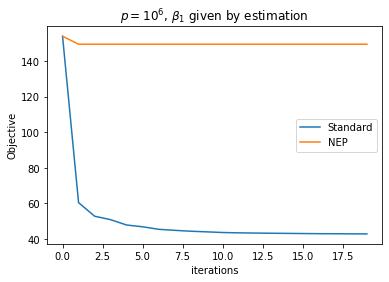

In [32]:
#plt.plot(np.arange(T),Result2[1],label='NEPb1')
plt.plot(np.arange(T),Result[1],label='Standard')
plt.plot(np.arange(T),Result1[1],label='NEP')
plt.ylabel('Objective')
plt.xlabel('iterations')
plt.legend()
plt.title('$p=10^6$, $\\beta_1$ given by estimation ')
plt.savefig("PlotSioux1.jpg", dpi=1000)#ax.set_title(' zweidimensionalen normalverteilten Zufallsvariable in Form eines Histogramms')


### We can appreciate that the new Method seems much slower, we will therefore test different estimations for $\beta$

1 49288.38246493565 149.4056790860301 826600.0
2 49277.536498138965 149.40692110968112 826600.0
3 49266.54703933842 149.40833105527818 826600.0
4 49266.06268700276 149.4084455546883 826600.0
5 49265.579495456506 149.40856442417876 826600.0
6 49265.09746420418 149.40868766148992 826600.0
7 49264.61659275035 149.40881526436348 826600.0
8 49264.13688059976 149.40894723054234 826600.0
9 49263.65832725717 149.4090835577704 826600.0
10 49263.180932227464 149.4092242437929 826600.0
11 49262.704695015615 149.40936928635617 826600.0
12 49262.22961512669 149.4095186832078 826600.0
13 49261.75569206585 149.40967243209653 826600.0
14 49261.282925338346 149.40983053077224 826600.0
15 49260.8113144495 149.40999297698593 826600.0
16 49272.400570250684 149.40730468684137 826600.0
17 49271.90236536861 149.4073670043413 826600.0
18 49271.40532717971 149.40743371890292 826600.0
19 49270.90945518744 149.4075048282526 826600.0
20 49270.414748895295 149.4075803301179 826600.0


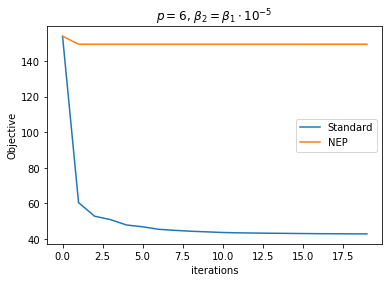

In [33]:
x0=Initial()
beta=beta/10**5
Result1=Frank_Wolfe_NEP(x0,T,beta)
#plt.plot(np.arange(T),Result2[1],label='NEPb1')
plt.plot(np.arange(T),Result[1],label='Standard')
plt.plot(np.arange(T),Result1[1],label='NEP')
plt.ylabel('Objective')
plt.xlabel('iterations')
plt.legend()
plt.title('$p=6$, $ \\beta_2=\\beta_1\cdot 10^{-5}$ ')
plt.savefig("PlotSioux2.jpg", dpi=1000)#ax.set_title(' zweidimensionalen normalverteilten Zufallsvariable in Form eines Histogramms')


### Setting as $\beta=\frac{\beta}{10^3}$ increases the convergence rate

1 49288.38246493565 149.4056790860301 826600.0
2 49267.795475268016 149.40598198764647 826600.0
3 49246.198832231436 149.4054361581141 826600.0
4 49313.16728190371 146.19237018685027 826600.0
5 50795.126075829896 142.80741442789434 826600.0
6 51360.70562924522 142.62199608173285 826600.0
7 53884.80718467344 132.3545926322038 826600.0
8 54302.92762688132 132.23704204736538 826600.0
9 56524.98416731709 124.04530219859943 826600.0
10 61535.14730733796 108.31086034757973 826600.0
11 61223.77253494797 108.28263616431111 826600.0
12 61224.13159475073 108.28263826044265 826600.0
13 62607.60943810178 105.16103487666325 826600.0
14 63225.49645891018 101.32875430639166 826600.0
15 63232.47735479025 101.32871332787087 826600.0
16 63232.57747965729 101.3287138094069 826600.0
17 63232.67759619302 101.32871432097396 826600.0
18 61335.070906797766 88.20419119491604 826600.0
19 61364.14447171298 88.16524859436502 826600.0
20 61369.46607530334 88.16493032743048 826600.0


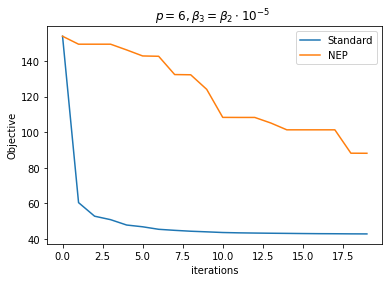

In [34]:
x0=Initial()
beta=beta/10**5
Result1=Frank_Wolfe_NEP(x0,T,beta)
#plt.plot(np.arange(T),Result2[1],label='NEPb1')
plt.plot(np.arange(T),Result[1],label='Standard')
plt.plot(np.arange(T),Result1[1],label='NEP')
plt.ylabel('Objective')
plt.xlabel('iterations')
plt.legend()
plt.title('$p=6,\\beta_3 =\\beta_2\cdot 10^{-5}$  ')
plt.savefig("Plotsioux3.jpg", dpi=1000)#ax.set_title(' zweidimensionalen normalverteilten Zufallsvariable in Form eines Histogramms')


1 19544.306493313135 56.498996617728814 1064300.0
2 13570.939349164702 50.53788558745739 906200.0
3 12108.256331029083 48.117437809194065 888000.0
4 9112.588682028292 46.79560760284344 900800.0
5 8513.17242044719 45.961123568138966 890700.0
6 7021.651765548175 45.42327792271043 877300.0
7 7465.476001539263 44.701840105072215 873500.0
8 6026.128421101909 44.275427881171645 891400.0
9 5898.718445467027 43.66989817631349 873500.0
10 4021.3874332248433 43.33522778255079 902100.0
11 3801.7429258698808 43.23955040234113 867000.0
12 3559.376438781786 43.126093252104866 867200.0
13 3483.286070306885 43.0470260072093 884100.0
14 3429.658810063589 42.97519001077056 871000.0
15 3049.5102759868632 42.90174291229655 870500.0
16 2952.9028307934855 42.85023498338962 887300.0
17 2938.1371428959874 42.79018081544446 870100.0
18 2906.462029982883 42.76132478333246 883200.0
19 2805.0656540862387 42.70421662581166 872500.0
20 2546.4987500076522 42.673455836138196 884200.0


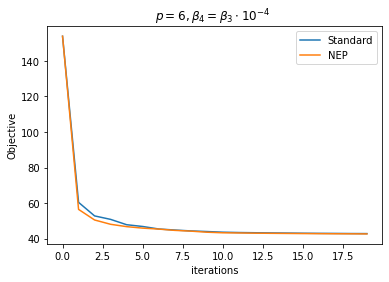

In [35]:
x0=Initial()
beta=beta/10**4
Result1=Frank_Wolfe_NEP(x0,T,beta)
#plt.plot(np.arange(T),Result2[1],label='NEPb1')
plt.plot(np.arange(T),Result[1],label='Standard')
plt.plot(np.arange(T),Result1[1],label='NEP')
plt.ylabel('Objective')
plt.xlabel('iterations')
plt.legend()
plt.title('$p=6,\\beta_4 =\\beta_3\cdot 10^{-4}$  ')
plt.savefig("Plotsiouxfinal.jpg", dpi=1000)#ax.set_title(' zweidimensionalen normalverteilten Zufallsvariable in Form eines Histogramms')


### resetting $\beta_1=\frac{\beta}{10^{14}}$ increases the convergence rate. Which means that the first estimation we proposed for $\beta$ does leave room for improvement.

In [36]:
beta

9.533949760577945e-06

# We now test how max percentage change behaves in both algorithms

This choice of stepsize is recommended in the 'Paper AN EFFICIENT APPROACH TO SOLVING THE ROAD NETWORK EQUILIBRIUM TRAFFIC ASSIGNMENT PROBLEM' by Leblanc, Morlok and Pieskalla.

In [37]:
def max_percentage_change(X_new,X_old):
    Diff=np.abs(X_old-X_new)
    Change=np.where(X_old>0,Diff/(X_old/100),0)
    
    return np.max(Change)

In [38]:

def Frank_Wolfe_percentage(xk,T,percentage):
    i=0
    
    A=[]
    while i<T:
        
        w=Oracle(xk)
        alpha_i=line_search(xk,w)
        X_old=xk
        xk=xk+alpha_i*(w-xk)
        X_new=xk
        print('percentage',max_percentage_change(X_new,X_old))
        A.append(max_percentage_change(X_new,X_old))

        i=i+1
        print(i,np.linalg.norm(xk-Optimal_flow),Objective(xk),np.sum(w))
 
    return xk,A

In [39]:

def Frank_Wolfe_NEP_percentage(xk,T,beta,percentage):
    '''
    This will be a modified version of the NEP algorithm to test the max_percentage influence in the results 
    '''
    i=0
    lamba=beta/2
    A=[]
    while i<T:
        #print(i,'XK',xk)
        stepi=stepsize1(i)
        lamba=beta*stepi/2
        w=NEP_Oracle(xk,lamba)
       
        #new=xk+stepi*(w-xk)
        alpha_i=line_search(xk,w)
   
        X_old=xk
        xk=xk+alpha_i*(w-xk)
        X_new=xk
        #if max_percentage_change(X_new,X_old)<percentage:
            
        #return xk,A
        i=i+1
        A.append(max_percentage_change(X_new,X_old))
        print(i,max_percentage_change(X_new,X_old),np.linalg.norm(xk-Optimal_flow),Objective(xk),np.sum(w))
        #if np.linalg.norm(last-xk)<20:
        #   return xk
    return xk,A

In [40]:
x0=Initial()
percentage=0.5
Result=Frank_Wolfe_percentage(x0,200,percentage)
Result1=Frank_Wolfe_NEP_percentage(x0,200,beta,percentage)

<ipython-input-37-05c28b79c98c>:3: RuntimeWarning: divide by zero encountered in true_divide
  Change=np.where(X_old>0,Diff/(X_old/100),0)
<ipython-input-37-05c28b79c98c>:3: RuntimeWarning: invalid value encountered in true_divide
  Change=np.where(X_old>0,Diff/(X_old/100),0)


percentage 1043.4747267698685
1 23701.566707488382 60.45188837073294 1163900.0
percentage 69.66704069198542
2 17423.007297747867 52.83358938161854 1000300.0
percentage 51.452435734635394
3 15949.406274089755 50.881545210747085 964200.0
percentage 45.75118907459703
4 15815.388658294638 47.87801768698962 904600.0
percentage 38.593668426765646
5 12308.096776777304 46.88694760668836 961500.0
percentage 33.62514799231091
6 12533.378229809246 45.47724002572441 900100.0
percentage 30.830638695977665
7 10439.985779898925 44.89279414404043 914500.0
percentage 22.46698622292825
8 8201.243024620024 44.39504568929955 871400.0
percentage 20.379220585769694
9 7250.760959100421 44.04666030435909 894300.0
percentage 16.769479528026043
10 7072.942066812526 43.67030905919762 888500.0
percentage 16.38742678977206
11 6147.358332512024 43.48609405204043 878900.0
percentage 10.048805536644746
12 5431.890584855139 43.366177836273934 871400.0
percentage 9.674853292118321
13 4909.970746711185 43.26417215386176

percentage 0.9997556454851522
108 645.3506708921267 42.351144106745345 866200.0
percentage 1.141993487192632
109 675.1943709423712 42.35079966403024 888800.0
percentage 0.6207266062976878
110 735.7144859356177 42.35053540612028 891600.0
percentage 1.1067218811978725
111 659.1333222871898 42.34992258710351 869100.0
percentage 1.1183573572100383
112 630.3370598616451 42.34942391668044 865800.0
percentage 1.1311709920670998
113 690.4282941065254 42.34897763107246 888800.0
percentage 0.9055965475213327
114 688.0177872713385 42.34863155357788 871500.0
percentage 1.0214423617996298
115 679.4393241826606 42.348184026515895 871300.0
percentage 1.2848298794043187
116 728.1562009272704 42.34778772692161 903000.0
percentage 2.3396850671233964
117 671.7319298816341 42.346836438334975 870700.0
percentage 1.012264607323955
118 693.5466218936015 42.34653297065261 898100.0
percentage 1.0176680075693827
119 702.7469838431297 42.34632766994312 888700.0
percentage 1.094442050228889
120 659.9168494413964 

14 8.982071683770691 3429.658810063589 42.97519001077056 871000.0
15 8.691438662477879 3049.5102759868632 42.90174291229655 870500.0
16 8.963929012143158 2952.9028307934855 42.85023498338962 887300.0
17 7.766275245858897 2938.1371428959874 42.79018081544446 870100.0
18 6.513995608141632 2906.462029982883 42.76132478333246 883200.0
19 8.201986697948907 2805.0656540862387 42.70421662581166 872500.0
20 7.657157240551755 2546.4987500076522 42.673455836138196 884200.0
21 5.51808928110851 2525.473933076132 42.653932441959974 868700.0
22 4.591155107886334 2541.120043676718 42.63459760514984 882200.0
23 4.13976276718909 2505.525571238119 42.617963349771024 883700.0
24 3.933727421799749 2516.4620129165282 42.60339603354087 872500.0
25 4.69412464881215 2498.725118091226 42.59011785330156 866800.0
26 4.252780152897303 2511.593332858262 42.57639424671936 870700.0
27 4.4244802590401315 2423.51109337551 42.56453902647717 872500.0
28 3.288291784674918 2373.772674168784 42.55121187737342 885900.0
29 3

136 1.2328897615332202 557.1513693355447 42.338237390761414 869000.0
137 1.0954359400103921 507.69285460519865 42.33790109929732 891700.0
138 0.7499438295127367 508.51219230075867 42.33735027561339 870800.0
139 1.0168134115193512 506.57441231013644 42.33703824163815 904400.0
140 0.7920666792353483 494.6758456068141 42.33682413030363 868700.0
141 0.820272016448055 523.6331952719414 42.336534657552065 869100.0
142 0.7684825398719196 510.3122413868645 42.336335718311716 887700.0
143 0.7478786443892983 514.504290646233 42.336031751196664 869500.0
144 0.943489194742728 514.1232057929615 42.33575549096415 885800.0
145 0.9503153209642106 510.2080901821331 42.33541270260445 868600.0
146 0.8803821765695301 493.57710374583974 42.33532243926436 897900.0
147 1.1057786642686207 510.0562430610464 42.33497343872889 870800.0
148 0.6804875376714252 499.62677094610217 42.33484112020568 868300.0
149 0.974522622298739 488.7200130321158 42.33453852403006 889600.0
150 0.6360079779296306 494.6082366419181 42

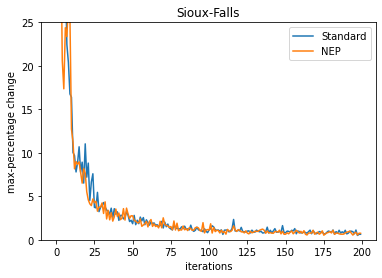

In [41]:
T=np.arange(200)
plt.ylim(0,25)
plt.plot(T,Result[1],label='Standard')
plt.plot(T,Result1[1],label='NEP')
plt.legend()
plt.title('Sioux-Falls')
plt.ylabel('max-percentage change')
plt.xlabel('iterations')
plt.savefig("Plot_percentage_Sioux.jpg", dpi=1000)

In this case the Nearest Extreme Point oracle also produces similar results to the standard Frank-Wolfe algorithm.

In [42]:
beta

9.533949760577945e-06